In [1]:
# import desired libraries
import numpy as np
import pandas as pd
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

custom = {"axes.edgecolor": "red", "grid.linestyle": "dashed", "grid.color": "black"}
sns.set_style("darkgrid", rc=custom)

# bow methods
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier

# split train test datasets
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score

# feature scaling
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter("ignore")

In [2]:
# load datasets
train_df = pd.read_csv("/kaggle/input/cse-291-dsc-253-data-mining-challenge/train.csv")
test_df = pd.read_csv("/kaggle/input/cse-291-dsc-253-data-mining-challenge/test.csv")

In [3]:
# print num feats and datapoints
print("Train shape : ",train_df.shape)
print("Test shape : ",test_df.shape)

Train shape :  (13144, 62)
Test shape :  (10000, 61)


In [4]:
# Drop columns with more than 80% NaNs
train_df = train_df.dropna(axis=1, thresh=len(train_df) * 0.8)

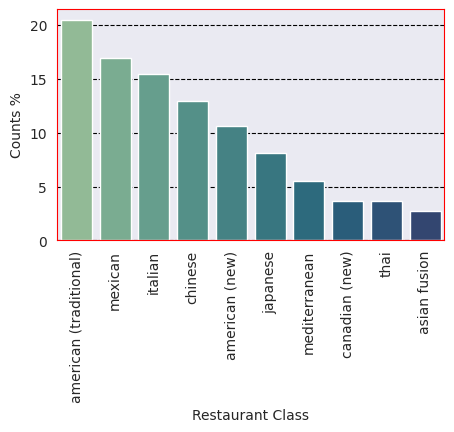

In [5]:
# check the cardinality of target distribution
rs_target = train_df['label'].value_counts(normalize=True) * 100

# target imbalance?
plt.figure(figsize=(5, 3))
sns.barplot(x=rs_target.index, y=rs_target.values, palette='crest')
plt.xlabel('Restaurant Class')
plt.xticks(rotation=90)
plt.ylabel('Counts %')
plt.show()

In [6]:
# check data-types and non-null counts of the features
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13144 entries, 0 to 13143
Data columns (total 33 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   13144 non-null  int64  
 1   attributes.Ambience                  11338 non-null  object 
 2   postal_code                          13144 non-null  object 
 3   attributes.OutdoorSeating            11845 non-null  object 
 4   hours.Saturday                       10525 non-null  object 
 5   longitude                            13144 non-null  float64
 6   name                                 13144 non-null  object 
 7   attributes.RestaurantsReservations   12135 non-null  object 
 8   hours.Friday                         10706 non-null  object 
 9   attributes.RestaurantsPriceRange2    12296 non-null  object 
 10  attributes.NoiseLevel                10552 non-null  object 
 11  state                       

In [7]:
# check missing values
train_df[['label', 'review']].isna().sum()

label     0
review    0
dtype: int64

In [8]:
# check a sample review
idx = 90
print(train_df["label"][idx], '\n')
print(train_df["review"][idx])

italian 

Great place around the corner from us. We drive by this place all the time and finally decided to go in. Pizzas were tasty and made on the spot and quickly. Will definitely be coming back. This place has a really nice modern aesthetic. I got the Pesto Toscano pizza and it was pretty good. The pizza crust is thick yet airy, with just the right amount of crunch on the exterior. The pizza would have been 5 stars if it weren't for the olives they used. I usually like olives but these olives were wayyyy too strong for the pizza. They overpowered all other flavors and that was disappointing because it was a great pizza otherwise. I would probably spring for the Margherita next time. I swung by Levetto tonight to check it out, since it\'s new to our neighbourhood. I had  the Funghi Pizza, which was delicious and an amazing value at 7$ for a "personal" size- a generous portion for one person. The toppings were super fresh and as I am a bit of a stickler for pizza crust, was happy to 

In [9]:
# ChatGPT
import ast
from datetime import datetime, timedelta

# Function to convert time in 'HH:MM' format to minutes past midnight
def time_to_minutes(t):
    hours, minutes = map(int, t.split(":"))
    return hours * 60 + minutes

# Function to handle closing times past midnight
def adjust_for_midnight(open_time, close_time):
    # If closing time is earlier than opening time, assume it's past midnight
    if close_time < open_time:
        close_time += 24 * 60  # add 24 hours in minutes
    return close_time

# Function to process restaurant hours
def process_hours(hours_str):
    hours_dict = ast.literal_eval(hours_str)  # Convert string to dictionary
    opening_hours = []
    closing_hours = []

    for day, times in hours_dict.items():
        open_time_str, close_time_str = times.split('-')
        open_time = time_to_minutes(open_time_str)
        close_time = time_to_minutes(close_time_str)
        
        # Adjust for closing time past midnight
        close_time = adjust_for_midnight(open_time, close_time)
        
        opening_hours.append(open_time)
        closing_hours.append(close_time)
    
    return opening_hours, closing_hours

# Function to calculate features
def calculate_features(hours_str):
    if pd.isna(hours_str):
        return np.nan, np.nan, np.nan  # Return NaN if the hours data is missing
        
    opening_hours, closing_hours = process_hours(hours_str)
    
    # Average Opening Hour
    avg_open = np.mean(opening_hours)
    
    # Average Closing Hour
    avg_close = np.mean(closing_hours)
    
    # Average Opening Duration (duration of opening time each day)
    avg_duration = np.mean([close - open for open, close in zip(opening_hours, closing_hours)])

    # total hours opened
    total_duration = np.sum([close - open for open, close in zip(opening_hours, closing_hours)])
    
    return avg_open, avg_close, avg_duration, total_duration

# Apply the feature calculation function to the 'hours' column and create new columns
train_df[['avg_open', 'avg_close', 'avg_duration', 'total_duration']] = train_df['hours'].apply(lambda x: pd.Series(calculate_features(x)))
test_df[['avg_open', 'avg_close', 'avg_duration', 'total_duration']] = test_df['hours'].apply(lambda x: pd.Series(calculate_features(x)))

In [10]:
def impute_missing_values(train_df, test_df):
    # List of columns to impute
    cols_to_impute = ['avg_open', 'avg_close', 'avg_duration', 'total_duration']
    
    # Function to impute by city and then state
    def impute_by_city_and_state(df):
        # Step 1: Impute missing values by city
        df[cols_to_impute] = df.groupby('city')[cols_to_impute].transform(
            lambda x: x.fillna(x.mean())
        )

        # Step 2: Identify rows where missing values still exist after city-based imputation
        nan_mask = df[cols_to_impute].isna()

        # Step 3: Impute missing values by state, but only for rows where city imputation was insufficient
        df.loc[nan_mask.any(axis=1), cols_to_impute] = df.groupby('state')[cols_to_impute].transform(
            lambda x: x.fillna(x.mean())
        )
        
        return df

    # Impute missing values for both train_df and test_df
    train_df = impute_by_city_and_state(train_df)
    test_df = impute_by_city_and_state(test_df)

    return train_df, test_df

train_df, test_df = impute_missing_values(train_df, test_df)

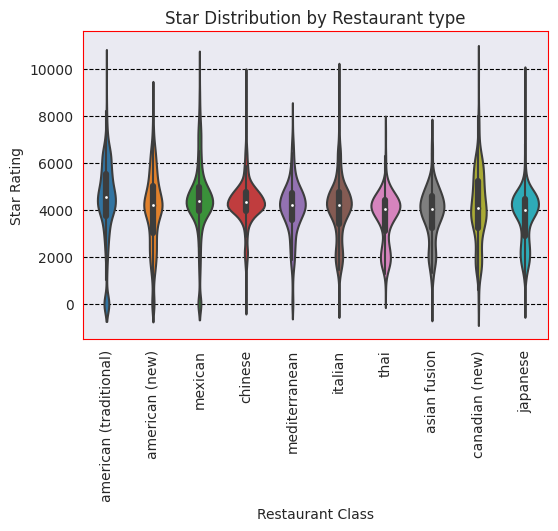

In [11]:
# check star distribution of opening hours restaurant types
plt.figure(figsize=(6,4))
sns.violinplot(x='label', y='total_duration', data=train_df)
plt.title('Star Distribution by Restaurant type')
plt.xlabel('Restaurant Class')
plt.ylabel('Star Rating')
plt.xticks(rotation=90)
plt.show()

In [12]:
# convert categorical to int
def map_cat_codes(col):
    # convert categorical to int
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')
    category_mapping = dict(enumerate(train_df[col].cat.categories))
    train_df[col] = train_df[col].cat.codes

    # Set test set categories to match train set categories
    reversed_category_mapping_dict = {v: k for k, v in category_mapping.items()}
    print(reversed_category_mapping_dict)
    
    # Map using the reversed dictionary
    test_df[col] = test_df[col].map(reversed_category_mapping_dict)
    # test_df[col] = test_df[col].fillna(len(reversed_category_mapping_dict)+1)    

In [13]:
def standardize_attire(val):
    # Handle byte strings (e.g., b"u'casual'", b"'casual'") and decode them
    if isinstance(val, bytes):
        val = val.decode('utf-8')  # Decode bytes to string

    # Handle NaN explicitly
    if pd.isna(val):
        return "casual"  # Or return np.nan or another default value
    
    # Normalize attire values (e.g., merge all variations of casual, dressy, etc.)
    if "casual" in val.lower():
        return "casual"
    elif "dressy" in val.lower():
        return "dressy"
    elif "formal" in val.lower():
        return "formal"
    elif 'none' in val.lower() or pd.isna(val):
        return "casual"  # Or replace with 'None' or another default value
    
    return val  # Return the original value if it's neither 'None' nor a known attire value
    
# Apply the function to the column
train_df['attire'] = train_df['attributes.RestaurantsAttire'].apply(standardize_attire)
test_df['attire'] = test_df['attributes.RestaurantsAttire'].apply(standardize_attire)
print(train_df['attire'].isna().sum())
print(train_df['attire'].value_counts())

# Convert the attire column to integer using the mapping
map_cat_codes('attire')

0
attire
casual    12739
dressy      380
formal       25
Name: count, dtype: int64
{'casual': 0, 'dressy': 1, 'formal': 2}


In [14]:
# Function to standardize and convert the column to integers
def standardize_price_range(val):    
    if isinstance(val, str) and val.startswith("b'") and val.endswith("'"):
        val = val[2:-1]  # Remove "b'" from the start and "'" from the end
    
    # Handle 'None' and 'None' (string or byte string)
    if val == 'None':
        return 0  # Replace 'None' with 0
    
    # Handle NaN explicitly
    if pd.isna(val):
        return 0  # Or return np.nan or another default value
    
    # Convert the value to integer (assuming val is now a string)
    return int(val)

# Apply the function to the column
train_df['price_range'] = train_df['attributes.RestaurantsPriceRange2'].apply(standardize_price_range)
test_df['price_range'] = test_df['attributes.RestaurantsPriceRange2'].apply(standardize_price_range)
print(train_df['price_range'].isna().sum())
print(train_df['price_range'].value_counts())

map_cat_codes('price_range')

0
price_range
2    7253
1    4229
0     852
3     686
4     124
Name: count, dtype: int64
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}


In [15]:
# Function to standardize the values in the column
def standardize_noise_level(val):
    # Handle 'None' and 'None' (string or byte string)
    if val == 'None' or val == b'None':
        return 'quiet'  # Replace 'None' with 'quiet'
    
    # Handle NaN explicitly
    if pd.isna(val):
        return 'quiet'  # Or return np.nan or another default value
    
    # Replace variations with standard values
    if "average" in val:
        return 'average'
    elif "quiet" in val:
        return 'quiet'
    elif "loud" in val:
        return 'loud'
    elif "very_loud" in val:
        return 'very_loud'
    elif "None" in val:
        return 'quiet'
    else:
        return val

# Apply the function to the column
train_df['noise_level'] = train_df['attributes.NoiseLevel'].apply(standardize_noise_level)
test_df['noise_level'] = test_df['attributes.NoiseLevel'].apply(standardize_noise_level)

print(train_df['noise_level'].isna().sum())
print(train_df['noise_level'].value_counts())

map_cat_codes('noise_level')

0
noise_level
average    7177
quiet      4727
loud       1240
Name: count, dtype: int64
{'average': 0, 'loud': 1, 'quiet': 2}


In [16]:
def standardize_alcohol(val):    
    # Handle 'None' and 'None' (string or byte string)
    if val == 'None' or val == b'None':
        return 'none'  # Replace 'None' with 'none'
    
    # Handle NaN explicitly
    if pd.isna(val):
        return 'none'  # Or return np.nan or another default value
    
    # Replace variations with standard values
    if "full_bar" in val:
        return 'full_bar'
    elif "none" in val.lower():
        return 'none'
    elif "beer_and_wine" in val:
        return 'beer_and_wine'
    else:
        return val

# Apply the function to the column
train_df['alcohol'] = train_df['attributes.Alcohol'].apply(standardize_alcohol)
test_df['alcohol'] = test_df['attributes.Alcohol'].apply(standardize_alcohol)

print(train_df['alcohol'].isna().sum())
print(train_df['alcohol'].value_counts())

map_cat_codes('alcohol')

0
alcohol
none             6072
full_bar         5299
beer_and_wine    1773
Name: count, dtype: int64
{'beer_and_wine': 0, 'full_bar': 1, 'none': 2}


In [17]:
def standardize_bool(val):
    # Handle 'None' and 'None' (string or byte string)
    if val == 'None' or val == b'None':
        return False  # Replace 'None' with False (no outdoor seating)
    
    # Handle NaN explicitly
    if pd.isna(val):
        return False  # Or return np.nan or another default value
    
    # Handle Boolean values (True or False)
    if 'true' in val.lower():
        return True
    elif 'false' in val.lower():
        return False
    else:
        return False  # Default to False for unrecognized values

# Apply the function to the column
train_df['reservation'] = train_df['attributes.RestaurantsReservations'].apply(standardize_bool)
train_df['good_for_gp'] = train_df['attributes.RestaurantsGoodForGroups'].apply(standardize_bool)
train_df['out_seating'] = train_df['attributes.OutdoorSeating'].apply(standardize_bool)
train_df['delivery'] = train_df['attributes.RestaurantsDelivery'].apply(standardize_bool)
train_df['good_for_kids'] = train_df['attributes.GoodForKids'].apply(standardize_bool)

test_df['reservation'] = test_df['attributes.RestaurantsReservations'].apply(standardize_bool)
test_df['good_for_gp'] = test_df['attributes.RestaurantsGoodForGroups'].apply(standardize_bool)
test_df['out_seating'] = test_df['attributes.OutdoorSeating'].apply(standardize_bool)
test_df['delivery'] = test_df['attributes.RestaurantsDelivery'].apply(standardize_bool)
test_df['good_for_kids'] = test_df['attributes.GoodForKids'].apply(standardize_bool)

print(train_df['good_for_gp'].isna().sum())
print(train_df['good_for_gp'].value_counts())

0
good_for_gp
True     11165
False     1979
Name: count, dtype: int64


In [18]:
# convert categorical to int
train_df['state'] = train_df['state'].astype('category')
category_mapping = dict(enumerate(train_df['state'].cat.categories))

train_df['state'] = train_df['state'].cat.codes

# apply the same encoding to the test data
test_df['state'] = test_df['state'].astype('category')

# Set test set categories to match train set categories
reversed_category_mapping_dict = {v: k for k, v in category_mapping.items()}

# Map using the reversed dictionary
test_df['state'] = test_df['state'].map(reversed_category_mapping_dict)
test_df['state'] = test_df['state'].fillna(len(reversed_category_mapping_dict)+1)

# Display the category to integer mapping
print("Category to Integer Mapping:", category_mapping)

Category to Integer Mapping: {0: "b'AB'", 1: "b'AZ'", 2: "b'IL'", 3: "b'NC'", 4: "b'NV'", 5: "b'OH'", 6: "b'ON'", 7: "b'PA'", 8: "b'QC'", 9: "b'SC'", 10: "b'VA'", 11: "b'WI'"}


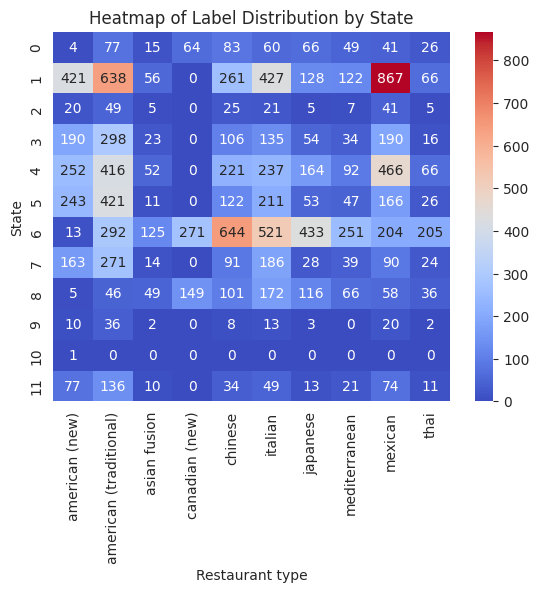

In [19]:
# check state wise distribution
heatmap_data = pd.crosstab(train_df['state'], train_df['label'])
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='d')
plt.title("Heatmap of Label Distribution by State")
plt.xlabel("Restaurant type")
plt.ylabel("State")
plt.show()

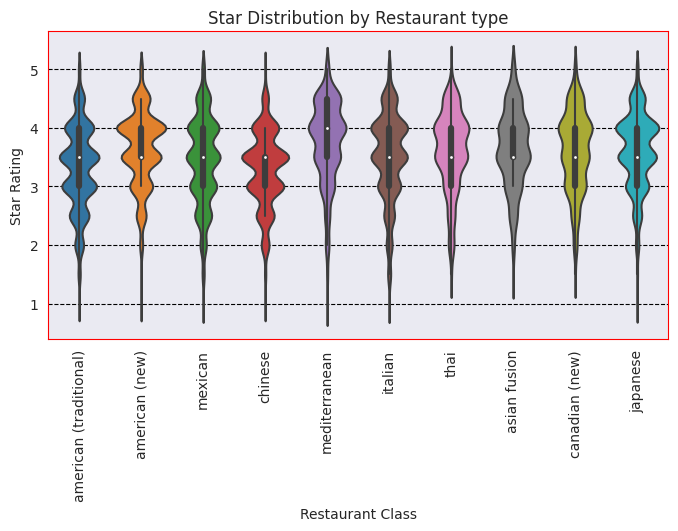

In [20]:
# check star distribution across restaurant types
plt.figure(figsize=(8, 4))
sns.violinplot(x='label', y='stars', data=train_df)
plt.title('Star Distribution by Restaurant type')
plt.xlabel('Restaurant Class')
plt.ylabel('Star Rating')
plt.xticks(rotation=90)
plt.show()

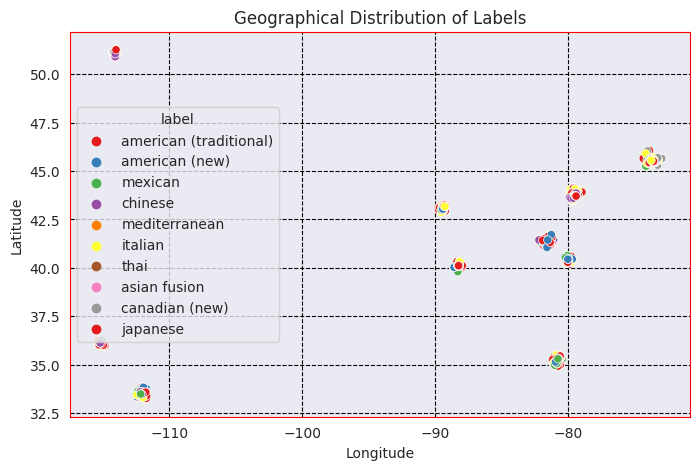

In [21]:
# check lat-long across restaurant types
plt.figure(figsize=(8, 5))
sns.scatterplot(data=train_df, x='longitude', y='latitude', hue='label', palette='Set1')
plt.title("Geographical Distribution of Labels")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

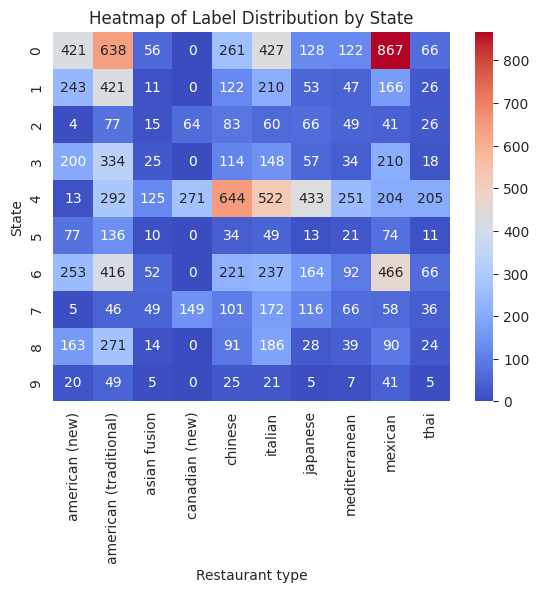

In [22]:
from sklearn.cluster import KMeans

# combine lat, lon into a 2D array
locations = train_df[['latitude', 'longitude']].values
kmeans = KMeans(n_clusters=10)  # 10 clusters as an example
train_df['location_cluster'] = kmeans.fit_predict(locations)
test_df['location_cluster'] = kmeans.fit_predict(test_df[['latitude', 'longitude']].values)

# check state wise distribution
heatmap_data = pd.crosstab(train_df['location_cluster'], train_df['label'])
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='d')
plt.title("Heatmap of Label Distribution by State")
plt.xlabel("Restaurant type")
plt.ylabel("State")
plt.show()

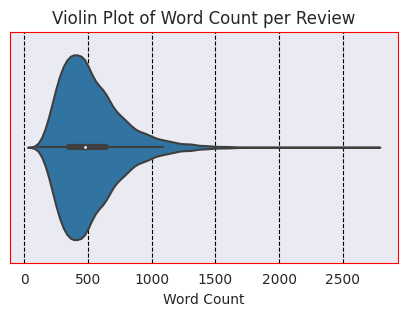

(525.5101947656725, 247.29966818641543)

In [23]:
# check review length distribution
lens = [len(review.split()) for review in train_df.review]

# calculate the statistics
plt.figure(figsize=(5,3))
sns.violinplot(x=lens)
plt.title('Violin Plot of Word Count per Review')
plt.xlabel('Word Count')
plt.show()

np.mean(lens), np.std(lens)

In [24]:
# non-null columns
non_null_columns = [
    "stars", "state", 'location_cluster',
    "is_open", 'avg_open', 'avg_close', 'avg_duration','total_duration', 
    'attire', 'price_range', 'noise_level', 'alcohol','reservation', 
    'good_for_gp', 'out_seating', 'delivery', 'good_for_kids'
]
train_df[non_null_columns].head()

,stars,state,location_cluster,is_open,avg_open,avg_close,avg_duration,total_duration,attire,price_range,noise_level,alcohol,reservation,good_for_gp,out_seating,delivery,good_for_kids
0,4.0,5,1,1,805.000000,1560.000000,755.000000,4530.000000,0,2,1,1,False,True,False,False,False
1,3.5,1,0,1,660.000000,1251.428571,591.428571,4140.000000,0,2,2,2,False,True,True,False,True
2,3.0,6,4,1,660.000000,1234.285714,574.285714,4020.000000,0,0,2,2,False,False,False,False,False
3,4.0,4,6,0,572.535387,1151.273154,578.737768,3957.983945,0,1,2,2,False,True,False,True,True
4,3.5,5,1,1,690.535714,1336.964286,646.428571,4312.500000,0,1,2,2,False,False,False,False,True


In [25]:
# use only the relevant columns
relevant_cols = non_null_columns + ['id', 'review', 'label']

train_df = train_df[[col for col in relevant_cols if col in train_df.columns]]
test_df = test_df[[col for col in relevant_cols if col in test_df.columns]]

print(train_df.shape, test_df.shape)

(13144, 20) (10000, 19)


In [26]:
# check if test has any nan
print(train_df[non_null_columns].isna().sum().sum())
print(test_df[non_null_columns].isna().sum().sum())

0
0


In [27]:
from sklearn.preprocessing import MinMaxScaler

# Feature Normalisation
scaler = MinMaxScaler()
train_df[non_null_columns] = scaler.fit_transform(train_df[non_null_columns])
test_df[non_null_columns] = scaler.transform(test_df[non_null_columns])

In [28]:
# preprocessing
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 

ps = PorterStemmer()
stop = set(stopwords.words('english'))

def clean_text(x, tokenise=False):
    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’' + '[\{\}\[\]\(\)]':
        x = x.replace(punct, '')

    tokens = x.lower().split(" ")
    tokens = [ps.stem(word) for word in tokens if word not in stop and 20>len(word)>1]

    if tokenise:
        return tokens
    
    return " ".join(tokens)

In [29]:
# apply preprocessing
train_df["review"] = train_df["review"].apply(lambda x: clean_text(x))
test_df["review"] = test_df["review"].apply(lambda x: clean_text(x))

In [30]:
# convert label col to int
train_df['label'] = train_df['label'].astype('category')
label_mapping = dict(enumerate(train_df['label'].cat.categories))
train_df['label'] = train_df['label'].cat.codes
print(label_mapping)

{0: 'american (new)', 1: 'american (traditional)', 2: 'asian fusion', 3: 'canadian (new)', 4: 'chinese', 5: 'italian', 6: 'japanese', 7: 'mediterranean', 8: 'mexican', 9: 'thai'}


In [31]:
## split to train and val
train_x, val_x, train_y, val_y = train_test_split(train_df, train_df['label'], test_size=0.1, random_state=2026)

# apply n-gram bow
# both single words and word pairs will be included as features in the vocabulary
count_vect = CountVectorizer(ngram_range=(1,2), max_features=200000, max_df=0.85) # word frequency
transformer = TfidfTransformer(norm='l2', sublinear_tf=True, smooth_idf=True)

train_x_counts = count_vect.fit_transform(train_x['review'])
train_x_tfidf = transformer.fit_transform(train_x_counts)

val_x_counts = count_vect.transform(val_x['review'])
val_x_tfidf = transformer.transform(val_x_counts)

test_x_counts = count_vect.transform(test_df['review'])
test_x_tfidf = transformer.transform(test_x_counts)

print(train_x_tfidf.shape, val_x_tfidf.shape, train_y.shape, val_y.shape)

(11829, 200000) (1315, 200000) (11829,) (1315,)


In [42]:
# combine other signals as well
from scipy.sparse import hstack

relevant_columns = [
    'location_cluster', "stars", "state", 
    'avg_open', 'avg_close', 'avg_duration','total_duration', 
    'attire', 'price_range', 'noise_level', 'alcohol','reservation', 
    'good_for_gp', 'out_seating', 'delivery', 'good_for_kids'
]

train_x_combined = hstack([train_x[relevant_columns], train_x_tfidf])
val_x_combined = hstack([val_x[relevant_columns], val_x_tfidf])
test_x_combined = hstack([test_df[relevant_columns], test_x_tfidf])

print(train_x_combined.shape)

(11829, 200016)


In [ ]:
# LOGISTIC REGRESSION
lr = LogisticRegression(C=2, max_iter=1000, n_jobs=-1)
lr.fit(train_x_combined, train_y)
val_y_pred_lr = lr.predict(val_x_combined)
print(f"Accuracy: {str(accuracy_score(val_y, val_y_pred_lr))}")
print(f"F1: {str(f1_score(val_y, val_y_pred_lr, average=None))}")
print(classification_report(val_y, val_y_pred_lr))

In [ ]:
# SUPPORT VECTOR MACHINE
svc = LinearSVC(C=2, class_weight="balanced")
svc.fit(train_x_combined, train_y)
val_y_pred_svc = svc.predict(val_x_combined)
print(f"Accuracy: {str(accuracy_score(val_y, val_y_pred_svc))}")
print(f"F1: {str(f1_score(val_y, val_y_pred_svc, average=None))}")
print(classification_report(val_y, val_y_pred_svc))

In [ ]:
# MULTINOMIAL NAIVE BAYES
mnb = MultinomialNB(alpha=0.03)
mnb.fit(train_x_combined, train_y)
val_y_pred_mnb = mnb.predict(val_x_combined)
print(f"Accuracy: {str(accuracy_score(val_y, val_y_pred_mnb))}")
print(f"F1: {str(f1_score(val_y, val_y_pred_mnb, average=None))}")
print(classification_report(val_y, val_y_pred_mnb))

In [ ]:
# RANDOM FOREST
rfc = RandomForestClassifier(
    n_estimators=300, 
    max_depth=20,
    class_weight='balanced'
)
rfc.fit(train_x_combined, train_y)
val_y_pred_rfc = rfc.predict(val_x_combined)
print(f"Accuracy: {str(accuracy_score(val_y, val_y_pred_rfc))}")
print(f"F1: {str(f1_score(val_y, val_y_pred_rfc, average=None))}")
print(classification_report(val_y, val_y_pred_rfc))

In [ ]:
# GRADIENT BOOSTING CLASSIFIER
gbc = GradientBoostingClassifier(
    n_estimators=20, 
    max_features='auto', 
    max_depth=4, 
    random_state=1, 
    verbose=1
)
gbc.fit(train_x_combined, train_y)
val_y_pred_gbc = gbc.predict(val_x_combined)
print(f"Accuracy: {str(accuracy_score(val_y, val_y_pred_gbc))}")
print(f"F1: {str(f1_score(val_y, val_y_pred_gbc, average=None))}")
print(classification_report(val_y, val_y_pred_gbc))

In [ ]:
# ENSEMBLE CLASSIFIER
ec = VotingClassifier(
    estimators=[ 
        ('Multinomial Naive Bayes', MultinomialNB(alpha=0.07)),
        ('Logistic Regression', LogisticRegression(C=2, max_iter=1000)),
        ('Support Vector Machine', LinearSVC())
    ], 
    voting='hard'
)

ec.fit(train_x_combined, train_y)
val_y_pred_ec = ec.predict(val_x_combined)
print(f"Accuracy: {str(accuracy_score(val_y, val_y_pred_ec))}")
print(f"F1: {str(f1_score(val_y, val_y_pred_ec, average=None))}")
print(classification_report(val_y, val_y_pred_ec))

In [ ]:
# NBSVM
# Step 2: Train Naive Bayes model
mnb = MultinomialNB()
mnb.fit(train_x_combined, train_y)

# Step 3: Transform the features using Naive Bayes log probabilities
log_prob_transformed = mnb.predict_log_proba(train_x_combined)

# Step 4: Train an SVM model on the transformed features
svm = SVC(kernel='linear')
svm.fit(log_prob_transformed, train_y)

# Step 5: Make predictions on val data
val_x_transformed = mnb.predict_log_proba(val_x_combined)
val_y_pred_svm = svm.predict(val_x_transformed)

print(f"Accuracy: {str(accuracy_score(val_y, val_y_pred_svm))}")
print(f"F1: {str(f1_score(val_y, val_y_pred_svm, average=None))}")
print(classification_report(val_y, val_y_pred_svm))

In [ ]:
# making Predictions on test data
predictions = svc.predict(test_x_combined)

# Map using the reversed dictionary
predictions_str = list(map(label_mapping.get, predictions))

In [ ]:
# clearly our submissions are evaluated on the basis of F1Score
submission = pd.DataFrame({'Id': test_df.id}, columns = ['Id'])
submission['Predicted'] = predictions_str
submission.to_csv('predicted.csv', index=False)